In [1]:
### Preparacion del dataset inicial
import pandas as pd
import numpy as np
import os
import sys
import re


In [2]:
def cargar_y_combinar_datos():
    # Cargar archivos
    sell_in = pd.read_csv('sell-in.txt', sep='\t')
    stocks = pd.read_csv('tb_stocks.txt', sep='\t')
    productos = pd.read_csv('tb_productos.txt', sep='\t')
    #drop duplicates in productos
    productos = productos.drop_duplicates(subset=['product_id'])

    df = sell_in.merge(stocks, on=['periodo', 'product_id'], how='left')
    df = df.merge(productos, on='product_id', how='left')

    return df

def transformar_periodo(df):
    df['fecha'] = pd.to_datetime(df['periodo'].astype(str), format='%Y%m')
    return df

def completar_series_temporales(df,umbral_meses=8):
    """
    Completa las series temporales de productos y clientes cuando AMBOS estaban activos.
    Un cliente o producto se considera 'MUERTO' si entre la ultima fecha del dataset y su ultima fecha de compra pasaron mas de X meses definido por un umbral.
    Para el resto, se considera activo desde su primera compra hasta el fin del dataset.
    """
    import pandas as pd

    df['fecha'] = df['fecha'].astype('period[M]')

    columnas_a_rellenar = ['cust_request_qty', 'cust_request_tn', 'tn']

    # Última fecha del dataset
    fecha_max_dataset = df['fecha'].max()

    # Definir umbral de inactividad
    umbral_fecha = fecha_max_dataset - umbral_meses

    # Fechas de inicio y fin por cliente y producto
    fechas_clientes = df.groupby('customer_id')['fecha'].agg(fecha_ini_c='min', fecha_fin_c='max').reset_index()
    fechas_productos = df.groupby('product_id')['fecha'].agg(fecha_ini_p='min', fecha_fin_p='max').reset_index()

    # Determinar cuáles clientes y productos están inactivos
    fechas_clientes['inactivo'] = fechas_clientes['fecha_fin_c'] <= umbral_fecha
    fechas_productos['inactivo'] = fechas_productos['fecha_fin_p'] <= umbral_fecha

    # Si está inactivo, se respeta la última fecha real; si no, se extiende hasta el final del dataset
    fechas_clientes['fecha_fin_c'] = fechas_clientes.apply(
        lambda x: x['fecha_fin_c'] if x['inactivo'] else fecha_max_dataset, axis=1
    )
    fechas_productos['fecha_fin_p'] = fechas_productos.apply(
        lambda x: x['fecha_fin_p'] if x['inactivo'] else fecha_max_dataset, axis=1
    )

    # Crear rango completo de fechas en formato Period[M]
    fechas = pd.period_range(df['fecha'].min(), fecha_max_dataset, freq='M')
    fechas_df = pd.DataFrame({'fecha': fechas})

    # Crear combinaciones válidas cliente-fecha
    clientes_fechas = fechas_clientes.merge(fechas_df, how='cross')
    clientes_fechas = clientes_fechas[
        (clientes_fechas['fecha'] >= clientes_fechas['fecha_ini_c']) &
        (clientes_fechas['fecha'] <= clientes_fechas['fecha_fin_c'])
    ][['customer_id', 'fecha']]

    # Crear combinaciones válidas producto-fecha
    productos_fechas = fechas_productos.merge(fechas_df, how='cross')
    productos_fechas = productos_fechas[
        (productos_fechas['fecha'] >= productos_fechas['fecha_ini_p']) &
        (productos_fechas['fecha'] <= productos_fechas['fecha_fin_p'])
    ][['product_id', 'fecha']]

    # Crear combinaciones cliente-producto-fecha donde ambos estaban activos
    combinaciones_validas = productos_fechas.merge(clientes_fechas, on='fecha', how='inner')

    # Merge con el dataset original
    df_completo = combinaciones_validas.merge(df, on=['product_id', 'customer_id', 'fecha'], how='left')

    # Completar valores faltantes con 0 en las columnas de cantidad
    df_completo[columnas_a_rellenar] = df_completo[columnas_a_rellenar].fillna(0)

    # Ordenar por producto, cliente y fecha
    df_completo = df_completo.sort_values(['product_id', 'customer_id', 'fecha'])

    return df_completo.reset_index(drop=True)

def crear_variable_objetivo(df):
    # Ordenar dataset por producto, cliente y fecha:
    df = df.sort_values(['product_id', 'customer_id', 'fecha'])
    df['target'] = df.groupby(['product_id', 'customer_id'])['tn'].shift(-2)
    return df

In [3]:
df = cargar_y_combinar_datos()
df = transformar_periodo(df)
df = completar_series_temporales(df, umbral_meses=10)
df = crear_variable_objetivo(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16181994 entries, 0 to 16181993
Data columns (total 15 columns):
 #   Column                 Dtype    
---  ------                 -----    
 0   product_id             int64    
 1   fecha                  period[M]
 2   customer_id            int64    
 3   periodo                float64  
 4   plan_precios_cuidados  float64  
 5   cust_request_qty       float64  
 6   cust_request_tn        float64  
 7   tn                     float64  
 8   stock_final            float64  
 9   cat1                   object   
 10  cat2                   object   
 11  cat3                   object   
 12  brand                  object   
 13  sku_size               float64  
 14  target                 float64  
dtypes: float64(8), int64(2), object(4), period[M](1)
memory usage: 1.9+ GB


In [4]:
df.head()

,product_id,fecha,customer_id,periodo,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,stock_final,cat1,cat2,cat3,brand,sku_size,target
0,20001,2017-01,10001,201701.0,0.0,11.0,99.43861,99.43861,NaN,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,92.46537
1,20001,2017-02,10001,201702.0,0.0,23.0,198.84365,198.84365,NaN,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,13.29728
2,20001,2017-03,10001,201703.0,0.0,33.0,92.46537,92.46537,NaN,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,101.00563
3,20001,2017-04,10001,201704.0,0.0,8.0,13.29728,13.29728,NaN,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,128.04792
4,20001,2017-05,10001,201705.0,0.0,15.0,101.20711,101.00563,NaN,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,101.20711


In [28]:
def weighted_subsample_series(
    df: pd.DataFrame,
    tn_col: str = "tn",
    sample_fraction: float = 0.25,
    random_state: int = 42
) -> pd.DataFrame:
    """
    Muestrea series (customer_id, product_id) de forma aleatoria pero ponderada
    por su promedio de `tn` (peso).

    Args:
        df (pd.DataFrame): Dataset original.
        tn_col (str): Nombre de la columna con los valores a promediar.
        sample_fraction (float): Fracción de series a seleccionar.
        random_state (int): Semilla para reproducibilidad.

    Returns:
        pd.DataFrame: Dataset filtrado con las series seleccionadas.
    """
    # 1. Calcular promedio de tn por serie
    series_avg_tn = (
        df.groupby(["customer_id", "product_id"])[tn_col]
        .mean()
        .reset_index(name="avg_tn")
    )

    # 2. Normalizar pesos (probabilidades) para muestreo
    series_avg_tn["sampling_weight"] = series_avg_tn["avg_tn"]

    # 3. Muestrear combinaciones con probabilidad proporcional a avg_tn
    sampled_series = series_avg_tn.sample(
        frac=sample_fraction,
        weights="sampling_weight",
        random_state=random_state
    )

    # 4. Filtrar dataset original
    df_subsampled = df.merge(
        sampled_series[["customer_id", "product_id"]],
        on=["customer_id", "product_id"],
        how="inner"
    )

    return df_subsampled


def custom_scaler(df, min_std_threshold=0.001):
    """
    Escala 'tn' usando std de (product_id, customer_id).
    Si esa std es < min_std_threshold o NaN, usa std de product_id como fallback.
    Si también es NaN, usa 1.0 para evitar división por cero.

    Args:
        df (pd.DataFrame): DataFrame con columnas ['product_id', 'customer_id', 'tn']
        min_std_threshold (float): Umbral mínimo para std_cust_prod

    Returns:
        pd.DataFrame con columnas:
            - 'std_cust_prod'
            - 'std_prod'
            - 'std_final'
            - 'tn_scaled'
    """
    # Calcular std por (product_id, customer_id)
    std_cust_prod = df.groupby(['product_id', 'customer_id'])['tn'].std().reset_index()
    std_cust_prod.rename(columns={'tn': 'std_cust_prod'}, inplace=True)

    # Calcular std por product_id
    std_prod = df.groupby('product_id')['tn'].std().reset_index()
    std_prod.rename(columns={'tn': 'std_prod'}, inplace=True)

    # Merge con DataFrame original
    df = df.merge(std_cust_prod, on=['product_id', 'customer_id'], how='left')
    df = df.merge(std_prod, on='product_id', how='left')

    # Inicializar std_final como copia de std_cust_prod
    df['std_final'] = df['std_cust_prod'].copy()

    # Máscara: casos donde std_cust_prod es inválido
    mask_invalid = (df['std_cust_prod'].isna()) | (df['std_cust_prod'] < min_std_threshold)

    # Asignar std_prod a esos casos
    df.loc[mask_invalid, 'std_final'] = df.loc[mask_invalid, 'std_prod']

    # Fallback final: si std_final sigue siendo NaN → poner 1.0
    df['std_final'] = df['std_final'].fillna(1.0)

    # Escalar
    df['tn_scaled'] = df['tn'] / df['std_final']

    return df


In [23]:
df_escalado = custom_scaler(df)
df_escalado.head()

,product_id,fecha,customer_id,periodo,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,stock_final,cat1,cat2,cat3,brand,sku_size,target,std_cust_prod,std_prod,std_final,tn_scaled
0,20001,2017-01,10001,201701.0,0.0,11.0,99.43861,99.43861,NaN,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,92.46537,106.032781,18.979251,106.032781,0.937810
1,20001,2017-02,10001,201702.0,0.0,23.0,198.84365,198.84365,NaN,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,13.29728,106.032781,18.979251,106.032781,1.875304
2,20001,2017-03,10001,201703.0,0.0,33.0,92.46537,92.46537,NaN,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,101.00563,106.032781,18.979251,106.032781,0.872045
3,20001,2017-04,10001,201704.0,0.0,8.0,13.29728,13.29728,NaN,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,128.04792,106.032781,18.979251,106.032781,0.125407
4,20001,2017-05,10001,201705.0,0.0,15.0,101.20711,101.00563,NaN,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,101.20711,106.032781,18.979251,106.032781,0.952589


In [27]:
#mostrar los registros de mayor valor de tn_scaled
top_escalado = df_escalado.nlargest(30, 'tn_scaled')[['product_id', 'customer_id', 'fecha', 'tn','tn_scaled','std_final']]
top_escalado

,product_id,customer_id,fecha,tn,tn_scaled,std_final
16176063,21290,10003,2017-08,0.00790,35.038767,0.000225
16131693,21271,10012,2018-01,0.02414,30.521188,0.000791
16131698,21271,10012,2018-06,0.02228,28.169514,0.000791
15892329,21224,10001,2017-06,0.03554,27.149533,0.001309
15899186,21224,10200,2017-02,0.03119,23.826503,0.001309
16179098,21294,10003,2017-08,0.00764,22.538855,0.000339
16177574,21291,10003,2017-08,0.01092,22.538855,0.000484
16181488,21299,10003,2017-08,0.00546,22.538855,0.000242
16178590,21293,10003,2017-08,0.00917,22.538855,0.000407
16180039,21296,10003,2017-08,0.00651,22.538855,0.000289


In [26]:
#mostrar los registros de mayor valor de tn_scaled
top_escalado = df_escalado.nlargest(50, 'tn')[['product_id', 'customer_id', 'fecha', 'tn','tn_scaled','std_final']]
top_escalado

,product_id,customer_id,fecha,tn,tn_scaled,std_final
18084,20002,10001,2019-11,547.87849,4.949263,110.699007
129,20001,10004,2018-10,469.45761,4.108218,114.272811
28,20001,10001,2019-05,439.90647,4.148778,106.032781
117,20001,10004,2017-10,437.37767,3.827487,114.272811
18083,20002,10001,2019-10,430.90803,3.892610,110.699007
120,20001,10004,2018-01,414.05146,3.623359,114.272811
136,20001,10004,2019-05,389.02653,3.404367,114.272811
24,20001,10001,2019-01,386.60688,3.646107,106.032781
127,20001,10004,2018-08,384.82574,3.367605,114.272811
114,20001,10004,2017-07,379.44270,3.320499,114.272811


In [ ]:
#mostrar los registros de menor valor de tn que sean mayores a 0
# (esto es para evitar mostrar registros con tn=0 que no aportan información)
top_escalado_menor = df_escalado[df_escalado['tn'] > 0.01].nsmallest(30,'tn')[['product_id', 'customer_id', 'fecha', 'tn','tn_scaled','std_final']]
top_escalado_menor

,product_id,customer_id,fecha,tn,tn_scaled,std_final
3922020,20234,10148,2017-03,0.01001,0.385932,0.025937
11846700,20793,10006,2018-05,0.01001,0.335646,0.029823
11846995,20793,10014,2018-12,0.01001,0.428443,0.023364
11847052,20793,10016,2017-09,0.01001,1.144900,0.008743
11847054,20793,10016,2017-11,0.01001,1.144900,0.008743
11847060,20793,10016,2018-05,0.01001,1.144900,0.008743
11847073,20793,10016,2019-06,0.01001,1.144900,0.008743
11847076,20793,10016,2019-09,0.01001,1.144900,0.008743
11847092,20793,10017,2018-01,0.01001,0.277875,0.036023
11847170,20793,10019,2018-07,0.01001,0.663149,0.015095


In [10]:
df_small = weighted_subsample_series(df,sample_fraction=0.30)
print(f"Filtrado: {len(df_small)} filas de {len(df)} originales")


Filtrado: 5928030 filas de 16181994 originales


In [11]:
#filtrar df_small por product_id 20001 y customer _id 10001
df_small = df_small[(df_small['product_id'] == 20001) & (df_small['customer_id'] == 10001)]
df_small

,product_id,fecha,customer_id,periodo,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,stock_final,cat1,cat2,cat3,brand,sku_size,target
0,20001,2017-01,10001,201701.0,0.0,11.0,99.43861,99.43861,NaN,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,92.46537
1,20001,2017-02,10001,201702.0,0.0,23.0,198.84365,198.84365,NaN,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,13.29728
2,20001,2017-03,10001,201703.0,0.0,33.0,92.46537,92.46537,NaN,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,101.00563
3,20001,2017-04,10001,201704.0,0.0,8.0,13.29728,13.29728,NaN,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,128.04792
4,20001,2017-05,10001,201705.0,0.0,15.0,101.20711,101.00563,NaN,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,101.20711
5,20001,2017-06,10001,201706.0,0.0,25.0,128.04792,128.04792,NaN,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,43.33930
6,20001,2017-07,10001,201707.0,0.0,18.0,101.20711,101.20711,NaN,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,289.35024
7,20001,2017-08,10001,201708.0,0.0,17.0,43.33930,43.33930,NaN,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,222.11389
8,20001,2017-09,10001,201709.0,0.0,36.0,289.35024,289.35024,NaN,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,111.54944
9,20001,2017-10,10001,201710.0,0.0,22.0,222.11389,222.11389,NaN,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,131.27150


In [17]:
from sklearn.preprocessing import RobustScaler, PowerTransformer, StandardScaler

def robust_then_normalize(df):
    # Paso 1: Filtrar columnas necesarias
    df = df[["customer_id", "product_id", "tn"]].copy()
    
    # Paso 2: Escalado robusto
    scaler = StandardScaler()
    df["tn_robust"] = scaler.fit_transform(df[["tn"]])
    
    # Paso 3: Normalización para que tenga forma más gaussiana
    normalizer = PowerTransformer(method="yeo-johnson")
    df["tn_robust_normalized"] = normalizer.fit_transform(df[["tn_robust"]])
    
    return df
df_transformed = robust_then_normalize(df)

In [ ]:
from sklearn.preprocessing import RobustScaler, PowerTransformer
import pandas as pd
import numpy as np

def robust_then_normalize_with_zeros(df):
    df = df[["customer_id", "product_id", "tn"]].copy()

    # Separar ceros y positivos
    mask_zeros = df["tn"] == 0
    mask_pos = df["tn"] > 0

    df_pos = df.loc[mask_pos, ["tn"]].copy()

    # Escalado robusto
    scaler = RobustScaler()
    tn_robust = scaler.fit_transform(df_pos)

    # Normalización Yeo-Johnson
    normalizer = PowerTransformer(method="yeo-johnson")
    tn_normalized = normalizer.fit_transform(tn_robust)

    # Insertar en el df original
    df["tn_transformed"] = np.nan
    df.loc[mask_zeros, "tn_transformed"] = 0
    df.loc[mask_pos, "tn_transformed"] = tn_normalized.flatten()

    return df
df_transformed_zeros = robust_then_normalize_with_zeros(df)


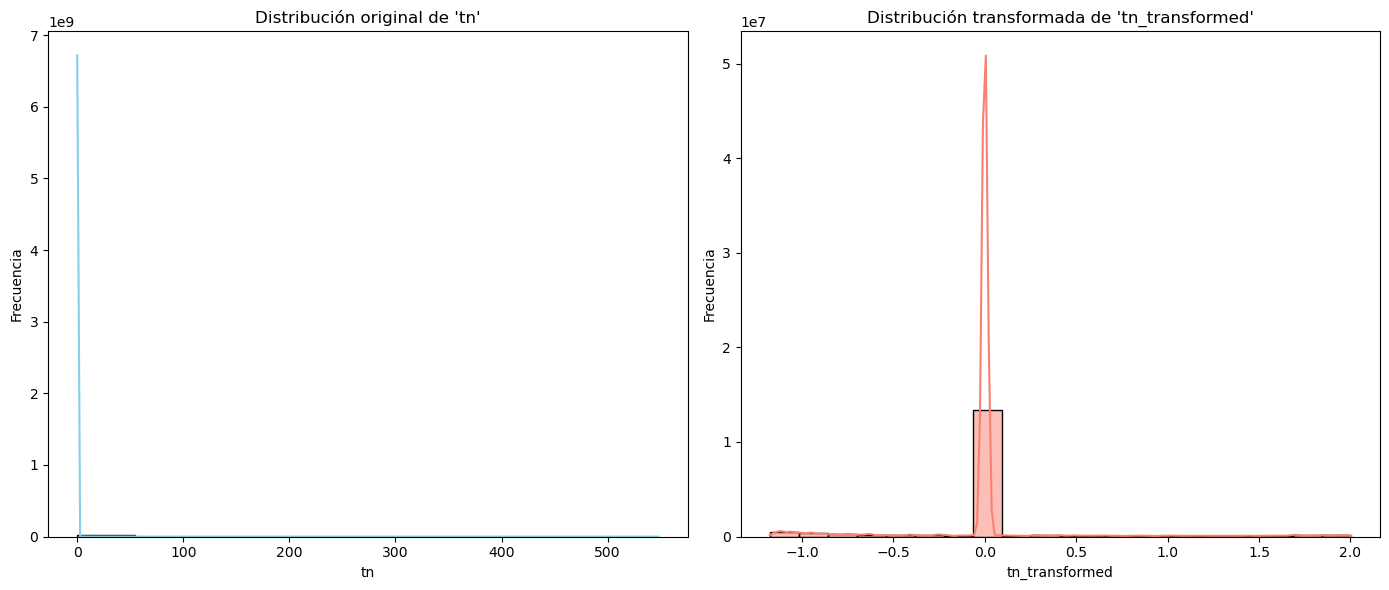

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_distribution_before_after(df_original, df_transformed):
    plt.figure(figsize=(14,6))

    plt.subplot(1, 2, 1)
    sns.histplot(df_original["tn"], bins=10, kde=True, color="skyblue")
    plt.title("Distribución original de 'tn'")
    plt.xlabel("tn")
    plt.ylabel("Frecuencia")

    plt.subplot(1, 2, 2)
    sns.histplot(df_transformed["tn_transformed"], bins=20, kde=True, color="salmon")
    plt.title("Distribución transformada de 'tn_transformed'")
    plt.xlabel("tn_transformed")
    plt.ylabel("Frecuencia")

    plt.tight_layout()
    plt.show()

# Ejemplo de uso
#df_transformed = robust_then_normalize_with_zeros(df)
plot_distribution_before_after(df, df_transformed)


In [52]:
q_low, q_high = df_transformed['tn_transformed'].quantile([0.40, 0.6])
df_trimmed = df_transformed[(df_transformed['tn_transformed'] >= q_low) & (df_transformed['tn_transformed'] <= q_high)]
print(f"df_trimmed tiene {len(df_trimmed)} filas")
print(f"Filas originales: {len(df_transformed)}")
print(f"Filas después del trimming: {len(df_trimmed)}")
print(f"Filas eliminadas: {len(df_transformed) - len(df_trimmed)}")
print(f"Porcentaje retenido: {len(df_trimmed)/len(df_transformed)*100:.2f}%")

df_trimmed tiene 13236176 filas
Filas originales: 16181994
Filas después del trimming: 13236176
Filas eliminadas: 2945818
Porcentaje retenido: 81.80%


In [54]:
# Sumar el tn total del df original y del df_trimmed
tn_total_original = df['tn'].sum()
tn_total_trimmed = df_trimmed['tn'].sum()

# Calcular el porcentaje
porcentaje_tn_acumulado = (tn_total_trimmed / tn_total_original) * 100

print(f"TN total original: {tn_total_original:,.2f}")
print(f"TN total en df_trimmed: {tn_total_trimmed:,.2f}")
print(f"Porcentaje de TN acumulado: {porcentaje_tn_acumulado:.2f}%")

TN total original: 1,324,988.59
TN total en df_trimmed: 0.00
Porcentaje de TN acumulado: 0.00%
